# Quaternion-Neural-Networks

## Group 43


source ([2019 code](https://github.com/heblol/Pytorch-Quaternion-Neural-Networks/blob/master/core_qnn/quaternion_layers.py)) - pytorch  

source ([2018 code](https://github.com/XYZ387/QuaternionCNN_Keras/blob/master/cifar10_cnn.py)) - tensorflow

<!-- @inproceedings{
parcollet2018quaternion,
title={Quaternion Recurrent Neural Networks},
author={Titouan Parcollet and Mirco Ravanelli and Mohamed Morchid and Georges Linarès and Chiheb Trabelsi and Renato De Mori and Yoshua Bengio},
booktitle={International Conference on Learning Representations},
year={2019},
url={https://openreview.net/forum?id=ByMHvs0cFQ},
} -->



In [ ]:
##########################################################
# pytorch-qnn v1.0
# Titouan Parcollet
# LIA, Université d'Avignon et des Pays du Vaucluse
# ORKIS, Aix-en-provence
# October 2018
##########################################################

import numpy                   as np
from   numpy.random            import RandomState
import torch
from   torch.autograd           import Variable
import torch.nn.functional      as F
import torch.nn                 as nn
from   torch.nn.parameter       import Parameter
from   torch.nn                 import Module


import math
import sys

# Imports for the quaternion_ops
import torch.nn as nn
from scipy.stats import chi
import pdb

# Import quaternion ops
core_qnn/quaternion_ops.py

I think these are helper functions.

In [ ]:
def q_normalize(input, channel=1):

    r = get_r(input)
    i = get_i(input)
    j = get_j(input)
    k = get_k(input)

    norm = torch.sqrt(r*r + i*i + j*j + k*k + 0.0001)
    r = r / norm
    i = i / norm
    j = j / norm
    k = k / norm

    return torch.cat([r,i,j,k], dim=channel)


def check_input(input):

    if input.dim() not in {2, 3, 4, 5}:
        raise RuntimeError(
            "Quaternion linear accepts only input of dimension 2 or 3. Quaternion conv accepts up to 5 dim "
            " input.dim = " + str(input.dim())
        )

    if input.dim() < 4:
        nb_hidden = input.size()[-1]
    else:
        nb_hidden = input.size()[1]

    if nb_hidden % 4 != 0:
        raise RuntimeError(
            "Quaternion Tensors must be divisible by 4."
            " input.size()[1] = " + str(nb_hidden)
        )
#
# Getters
#
def get_r(input):
    check_input(input)
    if input.dim() < 4:
        nb_hidden = input.size()[-1]
    else:
        nb_hidden = input.size()[1]

    if input.dim() == 2:
        return input.narrow(1, 0, nb_hidden // 4)
    if input.dim() == 3:
        return input.narrow(2, 0, nb_hidden // 4)
    if input.dim() >= 4:
        return input.narrow(1, 0, nb_hidden // 4)


def get_i(input):
    if input.dim() < 4:
        nb_hidden = input.size()[-1]
    else:
        nb_hidden = input.size()[1]
    if input.dim() == 2:
        return input.narrow(1, nb_hidden // 4, nb_hidden // 4)
    if input.dim() == 3:
        return input.narrow(2, nb_hidden // 4, nb_hidden // 4)
    if input.dim() >= 4:
        return input.narrow(1, nb_hidden // 4, nb_hidden // 4)

def get_j(input):
    check_input(input)
    if input.dim() < 4:
        nb_hidden = input.size()[-1]
    else:
        nb_hidden = input.size()[1]
    if input.dim() == 2:
        return input.narrow(1, nb_hidden // 2, nb_hidden // 4)
    if input.dim() == 3:
        return input.narrow(2, nb_hidden // 2, nb_hidden // 4)
    if input.dim() >= 4:
        return input.narrow(1, nb_hidden // 2, nb_hidden // 4)

def get_k(input):
    check_input(input)
    if input.dim() < 4:
        nb_hidden = input.size()[-1]
    else:
        nb_hidden = input.size()[1]
    if input.dim() == 2:
        return input.narrow(1, nb_hidden - nb_hidden // 4, nb_hidden // 4)
    if input.dim() == 3:
        return input.narrow(2, nb_hidden - nb_hidden // 4, nb_hidden // 4)
    if input.dim() >= 4:
        return input.narrow(1, nb_hidden - nb_hidden // 4, nb_hidden // 4)


def get_modulus(input, vector_form=False):
    check_input(input)
    r = get_r(input)
    i = get_i(input)
    j = get_j(input)
    k = get_k(input)
    if vector_form:
        return torch.sqrt(r * r + i * i + j * j + k * k)
    else:
        return torch.sqrt((r * r + i * i + j * j + k * k).sum(dim=0))


def get_normalized(input, eps=0.0001):
    check_input(input)
    data_modulus = get_modulus(input)
    if input.dim() == 2:
        data_modulus_repeated = data_modulus.repeat(1, 4)
    elif input.dim() == 3:
        data_modulus_repeated = data_modulus.repeat(1, 1, 4)
    return input / (data_modulus_repeated.expand_as(input) + eps)


def quaternion_exp(input):

    r      = get_r(input)
    i      = get_i(input)
    j      = get_j(input)
    k      = get_k(input)


    norm_v = torch.sqrt(i*i+j*j+k*k) + 0.0001
    exp    = torch.exp(r)

    r      = torch.cos(norm_v)
    i      = (i / norm_v) * torch.sin(norm_v)
    j      = (j / norm_v) * torch.sin(norm_v)
    k      = (k / norm_v) * torch.sin(norm_v)


    return torch.cat([exp*r, exp*i, exp*j, exp*k], dim=1)


def quaternion_conv(input, r_weight, i_weight, j_weight, k_weight, bias, stride,
                    padding, groups, dilatation):
    """
    Applies a quaternion convolution to the incoming data:
    """

    cat_kernels_4_r = torch.cat([r_weight, -i_weight, -j_weight, -k_weight], dim=1)
    cat_kernels_4_i = torch.cat([i_weight,  r_weight, -k_weight, j_weight], dim=1)
    cat_kernels_4_j = torch.cat([j_weight,  k_weight, r_weight, -i_weight], dim=1)
    cat_kernels_4_k = torch.cat([k_weight,  -j_weight, i_weight, r_weight], dim=1)

    cat_kernels_4_quaternion   = torch.cat([cat_kernels_4_r, cat_kernels_4_i, cat_kernels_4_j, cat_kernels_4_k], dim=0)

    if   input.dim() == 3:
        convfunc = F.conv1d
    elif input.dim() == 4:
        convfunc = F.conv2d
    elif input.dim() == 5:
        convfunc = F.conv3d
    else:
        raise Exception("The convolutional input is either 3, 4 or 5 dimensions."
                        " input.dim = " + str(input.dim()))

    return convfunc(input, cat_kernels_4_quaternion, bias, stride, padding, dilatation, groups)

def quaternion_transpose_conv(input, r_weight, i_weight, j_weight, k_weight, bias, stride,
                    padding, output_padding, groups, dilatation):
    """
    Applies a quaternion trasposed convolution to the incoming data:
    """

    cat_kernels_4_r = torch.cat([r_weight, -i_weight, -j_weight, -k_weight], dim=1)
    cat_kernels_4_i = torch.cat([i_weight,  r_weight, -k_weight, j_weight], dim=1)
    cat_kernels_4_j = torch.cat([j_weight,  k_weight, r_weight, -i_weight], dim=1)
    cat_kernels_4_k = torch.cat([k_weight,  -j_weight, i_weight, r_weight], dim=1)
    cat_kernels_4_quaternion   = torch.cat([cat_kernels_4_r, cat_kernels_4_i, cat_kernels_4_j, cat_kernels_4_k], dim=0)


    if   input.dim() == 3:
        convfunc = F.conv_transpose1d
    elif input.dim() == 4:
        convfunc = F.conv_transpose2d
    elif input.dim() == 5:
        convfunc = F.conv_transpose3d
    else:
        raise Exception("The convolutional input is either 3, 4 or 5 dimensions."
                        " input.dim = " + str(input.dim()))

    return convfunc(input, cat_kernels_4_quaternion, bias, stride, padding, output_padding, groups, dilatation)


def quaternion_conv_rotation(input, zero_kernel, r_weight, i_weight, j_weight, k_weight, bias, stride,
                    padding, groups, dilatation, quaternion_format, scale=None):
    """
    Applies a quaternion rotation and convolution transformation to the incoming data:
    The rotation W*x*W^t can be replaced by R*x following:
    https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation
    Works for unitary and non unitary weights.
    The initial size of the input must be a multiple of 3 if quaternion_format = False and
    4 if quaternion_format = True.
    """

    square_r          = (r_weight*r_weight)
    square_i          = (i_weight*i_weight)
    square_j          = (j_weight*j_weight)
    square_k          = (k_weight*k_weight)

    norm              = torch.sqrt(square_r+square_i+square_j+square_k + 0.0001)

    #print(norm)

    r_n_weight          = (r_weight / norm)
    i_n_weight          = (i_weight / norm)
    j_n_weight          = (j_weight / norm)
    k_n_weight          = (k_weight / norm)

    norm_factor       = 2.0

    square_i          = norm_factor*(i_n_weight*i_n_weight)
    square_j          = norm_factor*(j_n_weight*j_n_weight)
    square_k          = norm_factor*(k_n_weight*k_n_weight)

    ri                = (norm_factor*r_n_weight*i_n_weight)
    rj                = (norm_factor*r_n_weight*j_n_weight)
    rk                = (norm_factor*r_n_weight*k_n_weight)

    ij                = (norm_factor*i_n_weight*j_n_weight)
    ik                = (norm_factor*i_n_weight*k_n_weight)

    jk                = (norm_factor*j_n_weight*k_n_weight)

    if quaternion_format:
        if scale is not None:
            rot_kernel_1  = torch.cat([zero_kernel, scale * (1.0 - (square_j + square_k)), scale *(ij-rk), scale *(ik+rj)], dim=1)
            rot_kernel_2  = torch.cat([zero_kernel, scale *(ij+rk), scale *(1.0 - (square_i + square_k)), scale *(jk-ri)], dim=1)
            rot_kernel_3  = torch.cat([zero_kernel, scale *(ik-rj), scale *(jk+ri), scale *(1.0 - (square_i + square_j))], dim=1)
        else:
            rot_kernel_1  = torch.cat([zero_kernel, (1.0 - (square_j + square_k)), (ij-rk), (ik+rj)], dim=1)
            rot_kernel_2  = torch.cat([zero_kernel, (ij+rk), (1.0 - (square_i + square_k)), (jk-ri)], dim=1)
            rot_kernel_3  = torch.cat([zero_kernel, (ik-rj), (jk+ri), (1.0 - (square_i + square_j))], dim=1)

        zero_kernel2  = torch.cat([zero_kernel, zero_kernel, zero_kernel, zero_kernel], dim=1)
        global_rot_kernel = torch.cat([zero_kernel2, rot_kernel_1, rot_kernel_2, rot_kernel_3], dim=0)

    else:
        if scale is not None:
            rot_kernel_1  = torch.cat([scale * (1.0 - (square_j + square_k)), scale *(ij-rk), scale *(ik+rj)], dim=0)
            rot_kernel_2  = torch.cat([scale *(ij+rk), scale *(1.0 - (square_i + square_k)), scale *(jk-ri)], dim=0)
            rot_kernel_3  = torch.cat([scale *(ik-rj), scale *(jk+ri), scale *(1.0 - (square_i + square_j))], dim=0)
        else:
            rot_kernel_1  = torch.cat([1.0 - (square_j + square_k), (ij-rk), (ik+rj)], dim=0)
            rot_kernel_2  = torch.cat([(ij+rk), 1.0 - (square_i + square_k), (jk-ri)], dim=0)
            rot_kernel_3  = torch.cat([(ik-rj), (jk+ri), (1.0 - (square_i + square_j))], dim=0)

        global_rot_kernel = torch.cat([rot_kernel_1, rot_kernel_2, rot_kernel_3], dim=0)

    #print(input.shape)
    #print(square_r.shape)
    #print(global_rot_kernel.shape)

    if   input.dim() == 3:
        convfunc = F.conv1d
    elif input.dim() == 4:
        convfunc = F.conv2d
    elif input.dim() == 5:
        convfunc = F.conv3d
    else:
        raise Exception("The convolutional input is either 3, 4 or 5 dimensions."
                        " input.dim = " + str(input.dim()))

    return convfunc(input, global_rot_kernel, bias, stride, padding, dilatation, groups)

def quaternion_transpose_conv_rotation(input, zero_kernel, r_weight, i_weight, j_weight, k_weight, bias, stride,
                    padding, output_padding, groups, dilatation, quaternion_format):
    """
    Applies a quaternion rotation and transposed convolution transformation to the incoming data:
    The rotation W*x*W^t can be replaced by R*x following:
    https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation
    Works for unitary and non unitary weights.
    The initial size of the input must be a multiple of 3 if quaternion_format = False and
    4 if quaternion_format = True.
    """

    square_r          = (r_weight*r_weight)
    square_i          = (i_weight*i_weight)
    square_j          = (j_weight*j_weight)
    square_k          = (k_weight*k_weight)

    norm              = torch.sqrt(square_r+square_i+square_j+square_k + 0.0001)

    r_weight          = (r_weight / norm)
    i_weight          = (i_weight / norm)
    j_weight          = (j_weight / norm)
    k_weight          = (k_weight / norm)

    norm_factor       = 2.0

    square_i          = norm_factor*(i_weight*i_weight)
    square_j          = norm_factor*(j_weight*j_weight)
    square_k          = norm_factor*(k_weight*k_weight)

    ri                = (norm_factor*r_weight*i_weight)
    rj                = (norm_factor*r_weight*j_weight)
    rk                = (norm_factor*r_weight*k_weight)

    ij                = (norm_factor*i_weight*j_weight)
    ik                = (norm_factor*i_weight*k_weight)

    jk                = (norm_factor*j_weight*k_weight)

    if quaternion_format:
        rot_kernel_1  = torch.cat([zero_kernel, 1.0 - (square_j + square_k), ij-rk, ik+rj], dim=1)
        rot_kernel_2  = torch.cat([zero_kernel, ij+rk, 1.0 - (square_i + square_k), jk-ri], dim=1)
        rot_kernel_3  = torch.cat([zero_kernel, ik-rj, jk+ri, 1.0 - (square_i + square_j)], dim=1)

        zero_kernel2  = torch.zeros(rot_kernel_1.shape).cuda()
        global_rot_kernel = torch.cat([zero_kernel2, rot_kernel_1, rot_kernel_2, rot_kernel_3], dim=0)
    else:
        rot_kernel_1  = torch.cat([1.0 - (square_j + square_k), ij-rk, ik+rj], dim=1)
        rot_kernel_2  = torch.cat([ij+rk, 1.0 - (square_i + square_k), jk-ri], dim=1)
        rot_kernel_3  = torch.cat([ik-rj, jk+ri, 1.0 - (square_i + square_j)], dim=1)
        global_rot_kernel = torch.cat([rot_kernel_1, rot_kernel_2, rot_kernel_3], dim=0)


    if   input.dim() == 3:
        convfunc = F.conv_transpose1d
    elif input.dim() == 4:
        convfunc = F.conv_transpose2d
    elif input.dim() == 5:
        convfunc = F.conv_transpose3d
    else:
        raise Exception("The convolutional input is either 3, 4 or 5 dimensions."
                        " input.dim = " + str(input.dim()))

    return convfunc(input, cat_kernels_4_quaternion, bias, stride, padding, output_padding, groups, dilatation)


def quaternion_linear(input, r_weight, i_weight, j_weight, k_weight, bias=True):
    """
    Applies a quaternion linear transformation to the incoming data:
    It is important to notice that the forward phase of a QNN is defined
    as W * Inputs (with * equal to the Hamilton product). The constructed
    cat_kernels_4_quaternion is a modified version of the quaternion representation
    so when we do torch.mm(Input,W) it's equivalent to W * Inputs.
    """

    cat_kernels_4_r = torch.cat([r_weight, -i_weight, -j_weight, -k_weight], dim=0)
    cat_kernels_4_i = torch.cat([i_weight,  r_weight, -k_weight, j_weight], dim=0)
    cat_kernels_4_j = torch.cat([j_weight,  k_weight, r_weight, -i_weight], dim=0)
    cat_kernels_4_k = torch.cat([k_weight,  -j_weight, i_weight, r_weight], dim=0)
    cat_kernels_4_quaternion   = torch.cat([cat_kernels_4_r, cat_kernels_4_i, cat_kernels_4_j, cat_kernels_4_k], dim=1)

    if input.dim() == 2 :

        if bias is not None:
            return torch.addmm(bias, input, cat_kernels_4_quaternion)
        else:
            return torch.mm(input, cat_kernels_4_quaternion)
    else:
        output = torch.matmul(input, cat_kernels_4_quaternion)
        if bias is not None:
            return output+bias
        else:
            return output


def quaternion_linear_rotation(input, zero_kernel, r_weight, i_weight, j_weight, k_weight, bias=None,
                               quaternion_format=False, scale=None):
    """
    Applies a quaternion rotation transformation to the incoming data:
    The rotation W*x*W^t can be replaced by R*x following:
    https://en.wikipedia.org/wiki/Quaternions_and_spatial_rotation
    Works for unitary and non unitary weights.
    The initial size of the input must be a multiple of 3 if quaternion_format = False and
    4 if quaternion_format = True.
    """

    square_r          = (r_weight*r_weight)
    square_i          = (i_weight*i_weight)
    square_j          = (j_weight*j_weight)
    square_k          = (k_weight*k_weight)

    norm              = torch.sqrt(square_r+square_i+square_j+square_k + 0.0001)

    r_n_weight          = (r_weight / norm)
    i_n_weight          = (i_weight / norm)
    j_n_weight          = (j_weight / norm)
    k_n_weight          = (k_weight / norm)

    norm_factor       = 2.0

    square_i          = norm_factor*(i_n_weight*i_n_weight)
    square_j          = norm_factor*(j_n_weight*j_n_weight)
    square_k          = norm_factor*(k_n_weight*k_n_weight)

    ri                = (norm_factor*r_n_weight*i_n_weight)
    rj                = (norm_factor*r_n_weight*j_n_weight)
    rk                = (norm_factor*r_n_weight*k_n_weight)

    ij                = (norm_factor*i_n_weight*j_n_weight)
    ik                = (norm_factor*i_n_weight*k_n_weight)

    jk                = (norm_factor*j_n_weight*k_n_weight)

    if quaternion_format:
        if scale is not None:
            rot_kernel_1  = torch.cat([zero_kernel, scale * (1.0 - (square_j + square_k)), scale *(ij-rk), scale *(ik+rj)], dim=0)
            rot_kernel_2  = torch.cat([zero_kernel, scale *(ij+rk), scale *(1.0 - (square_i + square_k)), scale *(jk-ri)], dim=0)
            rot_kernel_3  = torch.cat([zero_kernel, scale *(ik-rj), scale *(jk+ri), scale *(1.0 - (square_i + square_j))], dim=0)
        else:
            rot_kernel_1  = torch.cat([zero_kernel, (1.0 - (square_j + square_k)), (ij-rk), (ik+rj)], dim=0)
            rot_kernel_2  = torch.cat([zero_kernel, (ij+rk), (1.0 - (square_i + square_k)), (jk-ri)], dim=0)
            rot_kernel_3  = torch.cat([zero_kernel, (ik-rj), (jk+ri), (1.0 - (square_i + square_j))], dim=0)

        zero_kernel2  = torch.cat([zero_kernel, zero_kernel, zero_kernel, zero_kernel], dim=0)
        global_rot_kernel = torch.cat([zero_kernel2, rot_kernel_1, rot_kernel_2, rot_kernel_3], dim=1)

    else:
        if scale is not None:
            rot_kernel_1  = torch.cat([scale * (1.0 - (square_j + square_k)), scale *(ij-rk), scale *(ik+rj)], dim=0)
            rot_kernel_2  = torch.cat([scale *(ij+rk), scale *(1.0 - (square_i + square_k)), scale *(jk-ri)], dim=0)
            rot_kernel_3  = torch.cat([scale *(ik-rj), scale *(jk+ri), scale *(1.0 - (square_i + square_j))], dim=0)
        else:
            rot_kernel_1  = torch.cat([1.0 - (square_j + square_k), (ij-rk), (ik+rj)], dim=0)
            rot_kernel_2  = torch.cat([(ij+rk), 1.0 - (square_i + square_k), (jk-ri)], dim=0)
            rot_kernel_3  = torch.cat([(ik-rj), (jk+ri), (1.0 - (square_i + square_j))], dim=0)

        global_rot_kernel = torch.cat([rot_kernel_1, rot_kernel_2, rot_kernel_3], dim=1)


    if input.dim() == 2 :
        if bias is not None:
            return torch.addmm(bias, input, global_rot_kernel)
        else:
            return torch.mm(input, global_rot_kernel)
    else:
        output = torch.matmul(input, global_rot_kernel)
        if bias is not None:
            return output+bias
        else:
            return output



# Custom AUTOGRAD for lower VRAM consumption
class QuaternionLinearFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input, r_weight, i_weight, j_weight, k_weight, bias=None):
        ctx.save_for_backward(input, r_weight, i_weight, j_weight, k_weight, bias)
        check_input(input)
        cat_kernels_4_r = torch.cat([r_weight, -i_weight, -j_weight, -k_weight], dim=0)
        cat_kernels_4_i = torch.cat([i_weight,  r_weight, -k_weight, j_weight], dim=0)
        cat_kernels_4_j = torch.cat([j_weight,  k_weight, r_weight, -i_weight], dim=0)
        cat_kernels_4_k = torch.cat([k_weight,  -j_weight, i_weight, r_weight], dim=0)
        cat_kernels_4_quaternion = torch.cat([cat_kernels_4_r, cat_kernels_4_i, cat_kernels_4_j, cat_kernels_4_k], dim=1)
        if input.dim() == 2 :
            if bias is not None:
                return torch.addmm(bias, input, cat_kernels_4_quaternion)
            else:
                return torch.mm(input, cat_kernels_4_quaternion)
        else:
            output = torch.matmul(input, cat_kernels_4_quaternion)
            if bias is not None:
                return output+bias
            else:
                return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):

        input, r_weight, i_weight, j_weight, k_weight, bias = ctx.saved_tensors
        grad_input = grad_weight_r = grad_weight_i = grad_weight_j = grad_weight_k = grad_bias = None

        input_r = torch.cat([r_weight, -i_weight, -j_weight, -k_weight], dim=0)
        input_i = torch.cat([i_weight,  r_weight, -k_weight, j_weight], dim=0)
        input_j = torch.cat([j_weight,  k_weight, r_weight, -i_weight], dim=0)
        input_k = torch.cat([k_weight,  -j_weight, i_weight, r_weight], dim=0)
        cat_kernels_4_quaternion_T = Variable(torch.cat([input_r, input_i, input_j, input_k], dim=1).permute(1,0), requires_grad=False)

        r = get_r(input)
        i = get_i(input)
        j = get_j(input)
        k = get_k(input)
        input_r = torch.cat([r, -i, -j, -k], dim=0)
        input_i = torch.cat([i,  r, -k, j], dim=0)
        input_j = torch.cat([j,  k, r, -i], dim=0)
        input_k = torch.cat([k,  -j, i, r], dim=0)
        input_mat = Variable(torch.cat([input_r, input_i, input_j, input_k], dim=1), requires_grad=False)

        r = get_r(grad_output)
        i = get_i(grad_output)
        j = get_j(grad_output)
        k = get_k(grad_output)
        input_r = torch.cat([r, i, j, k], dim=1)
        input_i = torch.cat([-i,  r, k, -j], dim=1)
        input_j = torch.cat([-j,  -k, r, i], dim=1)
        input_k = torch.cat([-k,  j, -i, r], dim=1)
        grad_mat = torch.cat([input_r, input_i, input_j, input_k], dim=0)

        if ctx.needs_input_grad[0]:
            grad_input  = grad_output.mm(cat_kernels_4_quaternion_T)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_mat.permute(1,0).mm(input_mat).permute(1,0)
            unit_size_x = r_weight.size(0)
            unit_size_y = r_weight.size(1)
            grad_weight_r = grad_weight.narrow(0,0,unit_size_x).narrow(1,0,unit_size_y)
            grad_weight_i = grad_weight.narrow(0,0,unit_size_x).narrow(1,unit_size_y,unit_size_y)
            grad_weight_j = grad_weight.narrow(0,0,unit_size_x).narrow(1,unit_size_y*2,unit_size_y)
            grad_weight_k = grad_weight.narrow(0,0,unit_size_x).narrow(1,unit_size_y*3,unit_size_y)
        if ctx.needs_input_grad[5]:
            grad_bias   = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight_r, grad_weight_i, grad_weight_j, grad_weight_k, grad_bias

def hamilton_product(q0, q1):
    """
    Applies a Hamilton product q0 * q1:
    Shape:
        - q0, q1 should be (batch_size, quaternion_number)
        (rr' - xx' - yy' - zz')  +
        (rx' + xr' + yz' - zy')i +
        (ry' - xz' + yr' + zx')j +
        (rz' + xy' - yx' + zr')k +
    """

    q1_r = get_r(q1)
    q1_i = get_i(q1)
    q1_j = get_j(q1)
    q1_k = get_k(q1)

    # rr', xx', yy', and zz'
    r_base = torch.mul(q0, q1)
    # (rr' - xx' - yy' - zz')
    r   = get_r(r_base) - get_i(r_base) - get_j(r_base) - get_k(r_base)

    # rx', xr', yz', and zy'
    i_base = torch.mul(q0, torch.cat([q1_i, q1_r, q1_k, q1_j], dim=1))
    # (rx' + xr' + yz' - zy')
    i   = get_r(i_base) + get_i(i_base) + get_j(i_base) - get_k(i_base)

    # ry', xz', yr', and zx'
    j_base = torch.mul(q0, torch.cat([q1_j, q1_k, q1_r, q1_i], dim=1))
    # (rx' + xr' + yz' - zy')
    j   = get_r(j_base) - get_i(j_base) + get_j(j_base) + get_k(j_base)

    # rz', xy', yx', and zr'
    k_base = torch.mul(q0, torch.cat([q1_k, q1_j, q1_i, q1_r], dim=1))
    # (rx' + xr' + yz' - zy')
    k   = get_r(k_base) + get_i(k_base) - get_j(k_base) + get_k(k_base)

    return torch.cat([r, i, j, k], dim=1)

#
# PARAMETERS INITIALIZATION
#

def unitary_init(in_features, out_features, rng, kernel_size=None, criterion='he'):

    if kernel_size is not None:
        receptive_field = np.prod(kernel_size)
        fan_in          = in_features  * receptive_field
        fan_out         = out_features * receptive_field
    else:
        fan_in          = in_features
        fan_out         = out_features


    if kernel_size is None:
        kernel_shape = (in_features, out_features)
    else:
        if type(kernel_size) is int:
            kernel_shape = (out_features, in_features) + tuple((kernel_size,))
        else:
            kernel_shape = (out_features, in_features) + (*kernel_size,)

    number_of_weights = np.prod(kernel_shape)
    v_r = np.random.uniform(-1.0,1.0,number_of_weights)
    v_i = np.random.uniform(-1.0,1.0,number_of_weights)
    v_j = np.random.uniform(-1.0,1.0,number_of_weights)
    v_k = np.random.uniform(-1.0,1.0,number_of_weights)

    # Unitary quaternion
    for i in range(0, number_of_weights):
        norm = np.sqrt(v_r[i]**2 + v_i[i]**2 + v_j[i]**2 + v_k[i]**2)+0.0001
        v_r[i]/= norm
        v_i[i]/= norm
        v_j[i]/= norm
        v_k[i]/= norm
    v_r = v_r.reshape(kernel_shape)
    v_i = v_i.reshape(kernel_shape)
    v_j = v_j.reshape(kernel_shape)
    v_k = v_k.reshape(kernel_shape)

    return (v_r, v_i, v_j, v_k)

def random_init(in_features, out_features, rng, kernel_size=None, criterion='glorot'):

    if kernel_size is not None:
        receptive_field = np.prod(kernel_size)
        fan_in          = in_features  * receptive_field
        fan_out         = out_features * receptive_field
    else:
        fan_in          = in_features
        fan_out         = out_features

    if criterion == 'glorot':
        s = 1. / np.sqrt(2*(fan_in + fan_out))
    elif criterion == 'he':
        s = 1. / np.sqrt(2*fan_in)
    else:
        raise ValueError('Invalid criterion: ' + criterion)

    if kernel_size is None:
        kernel_shape = (in_features, out_features)
    else:
        if type(kernel_size) is int:
            kernel_shape = (out_features, in_features) + tuple((kernel_size,))
        else:
            kernel_shape = (out_features, in_features) + (*kernel_size,)

    number_of_weights = np.prod(kernel_shape)
    v_r = np.random.uniform(-1.0,1.0,number_of_weights)
    v_i = np.random.uniform(-1.0,1.0,number_of_weights)
    v_j = np.random.uniform(-1.0,1.0,number_of_weights)
    v_k = np.random.uniform(-1.0,1.0,number_of_weights)



    v_r = v_r.reshape(kernel_shape)
    v_i = v_i.reshape(kernel_shape)
    v_j = v_j.reshape(kernel_shape)
    v_k = v_k.reshape(kernel_shape)

    weight_r = v_r
    weight_i = v_i
    weight_j = v_j
    weight_k = v_k
    return (weight_r, weight_i, weight_j, weight_k)


def quaternion_init(in_features, out_features, rng, kernel_size=None, criterion='glorot'):

    if kernel_size is not None:
        receptive_field = np.prod(kernel_size)
        fan_in          = in_features  * receptive_field
        fan_out         = out_features * receptive_field
    else:
        fan_in          = in_features
        fan_out         = out_features

    if criterion == 'glorot':
        s = 1. / np.sqrt(2*(fan_in + fan_out))
    elif criterion == 'he':
        s = 1. / np.sqrt(2*fan_in)
    else:
        raise ValueError('Invalid criterion: ' + criterion)

    rng = RandomState(np.random.randint(1,1234))

    # Generating randoms and purely imaginary quaternions :
    if kernel_size is None:
        kernel_shape = (in_features, out_features)
    else:
        if type(kernel_size) is int:
            kernel_shape = (out_features, in_features) + tuple((kernel_size,))
        else:
            kernel_shape = (out_features, in_features) + (*kernel_size,)

    modulus = chi.rvs(4,loc=0,scale=s,size=kernel_shape)
    number_of_weights = np.prod(kernel_shape)
    v_i = np.random.uniform(-1.0,1.0,number_of_weights)
    v_j = np.random.uniform(-1.0,1.0,number_of_weights)
    v_k = np.random.uniform(-1.0,1.0,number_of_weights)

    # Purely imaginary quaternions unitary
    for i in range(0, number_of_weights):
        norm = np.sqrt(v_i[i]**2 + v_j[i]**2 + v_k[i]**2 +0.0001)
        v_i[i]/= norm
        v_j[i]/= norm
        v_k[i]/= norm
    v_i = v_i.reshape(kernel_shape)
    v_j = v_j.reshape(kernel_shape)
    v_k = v_k.reshape(kernel_shape)

    phase = rng.uniform(low=-np.pi, high=np.pi, size=kernel_shape)

    weight_r = modulus * np.cos(phase)
    weight_i = modulus * v_i*np.sin(phase)
    weight_j = modulus * v_j*np.sin(phase)
    weight_k = modulus * v_k*np.sin(phase)

    return (weight_r, weight_i, weight_j, weight_k)

def create_dropout_mask(dropout_p, size, rng, as_type, operation='linear'):
    if operation == 'linear':
        mask = rng.binomial(n=1, p=1-dropout_p, size=size)
        return Variable(torch.from_numpy(mask).type(as_type))
    else:
         raise Exception("create_dropout_mask accepts only 'linear'. Found operation = "
                        + str(operation))

def affect_init(r_weight, i_weight, j_weight, k_weight, init_func, rng, init_criterion):
    if r_weight.size() != i_weight.size() or r_weight.size() != j_weight.size() or \
    r_weight.size() != k_weight.size() :
         raise ValueError('The real and imaginary weights '
                 'should have the same size . Found: r:'
                 + str(r_weight.size()) +' i:'
                 + str(i_weight.size()) +' j:'
                 + str(j_weight.size()) +' k:'
                 + str(k_weight.size()))

    elif r_weight.dim() != 2:
        raise Exception('affect_init accepts only matrices. Found dimension = '
                        + str(r_weight.dim()))
    kernel_size = None
    r, i, j, k  = init_func(r_weight.size(0), r_weight.size(1), rng, kernel_size, init_criterion)
    r, i, j, k  = torch.from_numpy(r), torch.from_numpy(i), torch.from_numpy(j), torch.from_numpy(k)
    r_weight.data = r.type_as(r_weight.data)
    i_weight.data = i.type_as(i_weight.data)
    j_weight.data = j.type_as(j_weight.data)
    k_weight.data = k.type_as(k_weight.data)


def affect_init_conv(r_weight, i_weight, j_weight, k_weight, kernel_size, init_func, rng,
                     init_criterion):
    if r_weight.size() != i_weight.size() or r_weight.size() != j_weight.size() or \
    r_weight.size() != k_weight.size() :
         raise ValueError('The real and imaginary weights '
                 'should have the same size . Found: r:'
                 + str(r_weight.size()) +' i:'
                 + str(i_weight.size()) +' j:'
                 + str(j_weight.size()) +' k:'
                 + str(k_weight.size()))

    elif 2 >= r_weight.dim():
        raise Exception('affect_conv_init accepts only tensors that have more than 2 dimensions. Found dimension = '
                        + str(real_weight.dim()))

    r, i, j, k = init_func(
        r_weight.size(1),
        r_weight.size(0),
        rng=rng,
        kernel_size=kernel_size,
        criterion=init_criterion
    )
    r, i, j, k = torch.from_numpy(r), torch.from_numpy(i), torch.from_numpy(j), torch.from_numpy(k)
    r_weight.data = r.type_as(r_weight.data)
    i_weight.data = i.type_as(i_weight.data)
    j_weight.data = j.type_as(j_weight.data)
    k_weight.data = k.type_as(k_weight.data)

def get_kernel_and_weight_shape(operation, in_channels, out_channels, kernel_size):
    if operation == 'convolution1d':
        if type(kernel_size) is not int:
            raise ValueError(
                """An invalid kernel_size was supplied for a 1d convolution. The kernel size
                must be integer in the case. Found kernel_size = """ + str(kernel_size)
            )
        else:
            ks = kernel_size
            w_shape = (out_channels, in_channels) + tuple((ks,))
    else:# in case it is 2d or 3d.
        if   operation == 'convolution2d' and type(kernel_size) is int:
            ks = (kernel_size, kernel_size)
        elif operation == 'convolution3d' and type(kernel_size) is int:
            ks = (kernel_size, kernel_size, kernel_size)
        elif type(kernel_size) is not int:
            if   operation == 'convolution2d' and len(kernel_size) != 2:
                raise ValueError(
                    """An invalid kernel_size was supplied for a 2d convolution. The kernel size
                    must be either an integer or a tuple of 2. Found kernel_size = """ + str(kernel_size)
                )
            elif operation == 'convolution3d' and len(kernel_size) != 3:
                raise ValueError(
                    """An invalid kernel_size was supplied for a 3d convolution. The kernel size
                    must be either an integer or a tuple of 3. Found kernel_size = """ + str(kernel_size)
                )
            else:
                ks = kernel_size
        w_shape = (out_channels, in_channels) + (*ks,)
    return ks, w_shape

# Setup the quaternion layers
core_qnn/quaternion_layers.py


In [ ]:
class QuaternionTransposeConv(Module):
    r"""Applies a Quaternion Transposed Convolution (or Deconvolution) to the incoming data.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 dilatation=1, padding=0, output_padding=0, groups=1, bias=True, init_criterion='he',
                 weight_init='quaternion', seed=None, operation='convolution2d', rotation=False,
                 quaternion_format=False):

        super(QuaternionTransposeConv, self).__init__()

        self.in_channels       = in_channels  // 4
        self.out_channels      = out_channels // 4
        self.stride            = stride
        self.padding           = padding
        self.output_padding    = output_padding
        self.groups            = groups
        self.dilatation        = dilatation
        self.init_criterion    = init_criterion
        self.weight_init       = weight_init
        self.seed              = seed if seed is not None else np.random.randint(0,1234)
        self.rng               = RandomState(self.seed)
        self.operation         = operation
        self.rotation          = rotation
        self.quaternion_format = quaternion_format
        self.winit             = {'quaternion': quaternion_init,
                                  'unitary'   : unitary_init,
                                  'random'    : random_init}[self.weight_init]


        (self.kernel_size, self.w_shape) = get_kernel_and_weight_shape( self.operation,
            self.out_channels, self.in_channels, kernel_size )

        self.r_weight  = Parameter(torch.Tensor(*self.w_shape))
        self.i_weight  = Parameter(torch.Tensor(*self.w_shape))
        self.j_weight  = Parameter(torch.Tensor(*self.w_shape))
        self.k_weight  = Parameter(torch.Tensor(*self.w_shape))


        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        affect_init_conv(self.r_weight, self.i_weight, self.j_weight, self.k_weight,
                    self.kernel_size, self.winit, self.rng, self.init_criterion)
        if self.bias is not None:
           self.bias.data.zero_()

    def forward(self, input):

        if self.rotation:
            return quaternion_tranpose_conv_rotation(input, self.r_weight, self.i_weight,
                self.j_weight, self.k_weight, self.bias, self.stride, self.padding,
                self.output_padding, self.groups, self.dilatation, self.quaternion_format)
        else:
            return quaternion_transpose_conv(input, self.r_weight, self.i_weight, self.j_weight,
                self.k_weight, self.bias, self.stride, self.padding, self.output_padding,
                self.groups, self.dilatation)


    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_channels='      + str(self.in_channels) \
            + ', out_channels='   + str(self.out_channels) \
            + ', bias='           + str(self.bias is not None) \
            + ', kernel_size='    + str(self.kernel_size) \
            + ', stride='         + str(self.stride) \
            + ', padding='        + str(self.padding) \
            + ', dilation='       + str(self.dilation) \
            + ', init_criterion=' + str(self.init_criterion) \
            + ', weight_init='    + str(self.weight_init) \
            + ', seed='           + str(self.seed) \
            + ', operation='      + str(self.operation) + ')'

In [ ]:
class QuaternionConv(Module):
    r"""Applies a Quaternion Convolution to the incoming data.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 dilatation=1, padding=0, groups=1, bias=True, init_criterion='glorot',
                 weight_init='quaternion', seed=None, operation='convolution2d', rotation=False, quaternion_format=True, scale=False):

        super(QuaternionConv, self).__init__()

        self.in_channels       = in_channels  // 4
        self.out_channels      = out_channels // 4
        self.stride            = stride
        self.padding           = padding
        self.groups            = groups
        self.dilatation        = dilatation
        self.init_criterion    = init_criterion
        self.weight_init       = weight_init
        self.seed              = seed if seed is not None else np.random.randint(0,1234)
        self.rng               = RandomState(self.seed)
        self.operation         = operation
        self.rotation          = rotation
        self.quaternion_format = quaternion_format
        self.winit             =    {'quaternion': quaternion_init,
                                     'unitary'   : unitary_init,
                                     'random'    : random_init}[self.weight_init]
        self.scale             = scale


        (self.kernel_size, self.w_shape) = get_kernel_and_weight_shape( self.operation,
            self.in_channels, self.out_channels, kernel_size )

        self.r_weight  = Parameter(torch.Tensor(*self.w_shape))
        self.i_weight  = Parameter(torch.Tensor(*self.w_shape))
        self.j_weight  = Parameter(torch.Tensor(*self.w_shape))
        self.k_weight  = Parameter(torch.Tensor(*self.w_shape))

        if self.scale:
            self.scale_param  = Parameter(torch.Tensor(self.r_weight.shape))
        else:
            self.scale_param  = None

        if self.rotation:
            self.zero_kernel = Parameter(torch.zeros(self.r_weight.shape), requires_grad=False)
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        affect_init_conv(self.r_weight, self.i_weight, self.j_weight, self.k_weight,
                    self.kernel_size, self.winit, self.rng, self.init_criterion)
        if self.scale_param is not None:
            torch.nn.init.xavier_uniform_(self.scale_param.data)
        if self.bias is not None:
           self.bias.data.zero_()

    def forward(self, input):


        if self.rotation:
            return quaternion_conv_rotation(input, self.zero_kernel, self.r_weight, self.i_weight, self.j_weight,
                self.k_weight, self.bias, self.stride, self.padding, self.groups, self.dilatation,
                self.quaternion_format, self.scale_param)
        else:
            return quaternion_conv(input, self.r_weight, self.i_weight, self.j_weight,
                self.k_weight, self.bias, self.stride, self.padding, self.groups, self.dilatation)


    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_channels='      + str(self.in_channels) \
            + ', out_channels='   + str(self.out_channels) \
            + ', bias='           + str(self.bias is not None) \
            + ', kernel_size='    + str(self.kernel_size) \
            + ', stride='         + str(self.stride) \
            + ', padding='        + str(self.padding) \
            + ', init_criterion=' + str(self.init_criterion) \
            + ', weight_init='    + str(self.weight_init) \
            + ', seed='           + str(self.seed) \
            + ', rotation='       + str(self.rotation) \
            + ', q_format='       + str(self.quaternion_format) \
            + ', operation='      + str(self.operation) + ')'

In [ ]:
class QuaternionLinearAutograd(Module):
    r"""Applies a quaternion linear transformation to the incoming data. A custom
    Autograd function is call to drastically reduce the VRAM consumption. Nonetheless, computing
    time is also slower compared to QuaternionLinear().
    """

    def __init__(self, in_features, out_features, bias=True,
                 init_criterion='glorot', weight_init='quaternion',
                 seed=None, rotation=False, quaternion_format=True, scale=False):

        super(QuaternionLinearAutograd, self).__init__()
        self.in_features       = in_features//4
        self.out_features      = out_features//4
        self.rotation          = rotation
        self.quaternion_format = quaternion_format
        self.r_weight = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.i_weight = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.j_weight = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.k_weight = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.scale    = scale

        if self.scale:
            self.scale_param  = Parameter(torch.Tensor(self.in_features, self.out_features))
        else:
            self.scale_param  = None

        if self.rotation:
            self.zero_kernel  = Parameter(torch.zeros(self.r_weight.shape), requires_grad=False)

        if bias:
            self.bias = Parameter(torch.Tensor(self.out_features*4))
        else:
            self.register_parameter('bias', None)
        self.init_criterion = init_criterion
        self.weight_init = weight_init
        self.seed = seed if seed is not None else np.random.randint(0,1234)
        self.rng = RandomState(self.seed)
        self.reset_parameters()

    def reset_parameters(self):
        winit = {'quaternion': quaternion_init, 'unitary': unitary_init, 'random': random_init}[self.weight_init]
        if self.scale_param is not None:
            torch.nn.init.xavier_uniform_(self.scale_param.data)
        if self.bias is not None:
            self.bias.data.fill_(0)
        affect_init(self.r_weight, self.i_weight, self.j_weight, self.k_weight, winit,
                    self.rng, self.init_criterion)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        if self.rotation:
            return quaternion_linear_rotation(input, self.zero_kernel, self.r_weight, self.i_weight, self.j_weight, self.k_weight, self.bias, self.quaternion_format, self.scale_param)
        else:
            return quaternion_linear(input, self.r_weight, self.i_weight, self.j_weight, self.k_weight, self.bias)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_features=' + str(self.in_features) \
            + ', out_features=' + str(self.out_features) \
            + ', bias=' + str(self.bias is not None) \
            + ', init_criterion=' + str(self.init_criterion) \
            + ', weight_init=' + str(self.weight_init) \
            + ', rotation='       + str(self.rotation) \
            + ', seed=' + str(self.seed) + ')'

In [ ]:
class QuaternionLinear(Module):
    r"""Applies a quaternion linear transformation to the incoming data.
    """

    def __init__(self, in_features, out_features, bias=True,
                 init_criterion='he', weight_init='quaternion',
                 seed=None):

        super(QuaternionLinear, self).__init__()
        self.in_features  = in_features//4
        self.out_features = out_features//4
        self.r_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.i_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.j_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))
        self.k_weight     = Parameter(torch.Tensor(self.in_features, self.out_features))

        if bias:
            self.bias     = Parameter(torch.Tensor(self.out_features*4))
        else:
            self.register_parameter('bias', None)

        self.init_criterion = init_criterion
        self.weight_init    = weight_init
        self.seed           = seed if seed is not None else np.random.randint(0,1234)
        self.rng            = RandomState(self.seed)
        self.reset_parameters()

    def reset_parameters(self):
        winit = {'quaternion': quaternion_init,
                 'unitary': unitary_init}[self.weight_init]
        if self.bias is not None:
            self.bias.data.fill_(0)
        affect_init(self.r_weight, self.i_weight, self.j_weight, self.k_weight, winit,
                    self.rng, self.init_criterion)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        if input.dim() == 3:
            T, N, C = input.size()
            input  = input.view(T * N, C)
            output = QuaternionLinearFunction.apply(input, self.r_weight, self.i_weight, self.j_weight, self.k_weight, self.bias)
            output = output.view(T, N, output.size(1))
        elif input.dim() == 2:
            output = QuaternionLinearFunction.apply(input, self.r_weight, self.i_weight, self.j_weight, self.k_weight, self.bias)
        else:
            raise NotImplementedError

        return output

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_features=' + str(self.in_features) \
            + ', out_features=' + str(self.out_features) \
            + ', bias=' + str(self.bias is not None) \
            + ', init_criterion=' + str(self.init_criterion) \
            + ', weight_init=' + str(self.weight_init) \
            + ', seed=' + str(self.seed) + ')'

# Reimplementation
## Import required packages

In [ ]:
# Import packages to import Cifar
from torchvision.datasets import CIFAR10
# from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchsummary import summary
from tqdm import tqdm

## Import CIFAR

In [ ]:
# Import Cifar10
import torchvision.transforms as transforms

def convert_to_quaternion(batch):
  new_batch = torch.empty(len(batch), 4, 32, 32)
  labels = torch.LongTensor(len(batch))

  # Transform images to quaternion matrices
  for i in range(len(batch)):
    image, label = batch[i][0], batch[i][1]
    real = torch.zeros(32, 32)
    new_image = torch.cat((image, real.unsqueeze(0)), dim=0)
    new_batch[i, :, :, :] = new_image
    labels[i] = label

  return new_batch, labels

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
    transforms.RandomHorizontalFlip(0.5)
])

train_dataset = CIFAR10(root='data/', download=True, transform=transform)
test_dataset = CIFAR10(root='data/', train=False, transform=transforms.ToTensor())

torch.manual_seed(43)
val_size = 0
train_size = len(train_dataset) - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

##############################################################################
# These values are directly copied from the Keras tensorflow implementation. #
##############################################################################
batch_size = 32

num_predictions = 20
# save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model_Q_REIMPLEMENTATION.h5'

# TODO:
# - they split the data into categorical data. Do we have to do this too?
# - Transfor data in pytorch, equaivilant of the data_agumentation in Tensorflow.

##############################################################################
# END END                                                                    #
##############################################################################

quaternion = False
if quaternion:
  train_loader = DataLoader(train_dataset, batch_size, shuffle=True, 
                          collate_fn=convert_to_quaternion)
  test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, 
                         pin_memory=True, collate_fn=convert_to_quaternion)
else:
  train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, 
                         pin_memory=True)

dataiter = iter(train_loader)
images, labels = next(dataiter)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [ ]:
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [ ]:
def try_gpu():
    """
    If GPU is available, return torch.device as cuda:0; else return torch.device
    as cpu.
    """
    if torch.cuda.is_available():
      print("Training on GPU")
      device = torch.device('cuda:0')
    else:
      print("Training on CPU")
      device = torch.device('cpu')
    return device

## Implement baseline 
referred in the paper as "real-valued CNN"

In [ ]:
class CNN(nn.Module):
    """
    3-layer CNN network with max pooling
    
    Args:
        in_channels: number of features of the input image ("depth of image")
        hidden_channels: number of hidden features ("depth of convolved images")
        out_features: number of features in output layer
    """
    
    def __init__(self, in_channels: int, hidden_channels, out_features: int, kernel_size: int):
        super(CNN, self).__init__()

        self.net = nn.Sequential(
          # block 1
          nn.Conv2d(in_channels, hidden_channels[0], kernel_size, padding=1),
          nn.ReLU(),
          nn.Conv2d(hidden_channels[0], hidden_channels[1], kernel_size),
          nn.ReLU(),
          nn.MaxPool2d(2, stride=2),
          torch.nn.Dropout(p=0.25),

          # block 2
          nn.Conv2d(hidden_channels[1], hidden_channels[2], kernel_size, padding=1),
          nn.ReLU(),
          nn.Conv2d(hidden_channels[2], hidden_channels[3], kernel_size),
          nn.ReLU(),
          nn.MaxPool2d(2, stride=2),
          torch.nn.Dropout(p=0.25),

          # block 3
          nn.Flatten(),
          nn.Linear(2304, 512),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(512, out_features),
          nn.Softmax()
        )
    
    def accuracy(self, outputs, labels):
      _, preds = torch.max(outputs, dim=1)

      return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def training_step(self, batch):
      images, labels = batch
      images, labels = images.to(device), labels.to(device)
      out = self(images)                  # Generate predictions
      loss = F.cross_entropy(out, labels) # Calculate loss
      accu = self.accuracy(out,labels)

      return loss, accu

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = self.accuracy(out, labels)           # Calculate accuracy

        return loss.detach(), acc
    
    def epoch_end(self, epoch, train_acc, train_loss, test_acc, test_loss):
        print("Epoch :",epoch + 1)
        print(f'Train Accuracy:{train_acc*100:.2f}% Validation Accuracy:{test_acc*100:.2f}%')
        print(f'Train Loss:{train_loss:.4f} Validation Loss:{test_loss:.4f}')

    def forward(self, x):
      return self.net.forward(x)
      


## Implement QNN

In [ ]:
class QNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_features, kernel_size = 3):
        super(QNN, self).__init__()
    
        self.net = nn.Sequential(
            # Padding
            QuaternionConv(in_channels, hidden_channels[0], 
                                     kernel_size, padding=1, stride=1),
            nn.ReLU(),
            QuaternionConv(hidden_channels[0], hidden_channels[1],
                              kernel_size, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=0.25),

            QuaternionConv(hidden_channels[1], hidden_channels[2],
                              kernel_size, padding=1, stride=1),
            nn.ReLU(),
            QuaternionConv(hidden_channels[2], hidden_channels[3],
                              kernel_size, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=0.25),

            nn.Flatten(),
            # QDense
            QuaternionLinear(2304, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            # Dense
            nn.Linear(512, out_features),
            nn.Softmax()
        )
    
    def accuracy(self, outputs, labels):
      _, preds = torch.max(outputs, dim=1)

      return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def training_step(self, batch):
      images, labels = batch
      images, labels = images.to(device), labels.to(device)
      out = self(images)                  # Generate predictions
      loss = F.cross_entropy(out, labels) # Calculate loss
      accu = self.accuracy(out, labels)

      return loss, accu

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = self.accuracy(out, labels)           # Calculate accuracy

        return loss.detach(), acc
    
    def epoch_end(self, epoch, train_acc, train_loss, test_acc, test_loss):
        print("Epoch :",epoch + 1)
        print(f'Train Accuracy:{train_acc*100:.2f}% Validation Accuracy:{test_acc*100:.2f}%')
        print(f'Train Loss:{train_loss:.4f} Validation Loss:{test_loss:.4f}')

    def forward(self, x):
      return self.net.forward(x)

In [ ]:
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR

if quaternion:
  in_channels = 4
  hidden_channels = [32, 32, 64, 64]
  out_features = 10

  net = QNN(in_channels, hidden_channels, out_features)
else:
  in_channels = 3
  hidden_channels = [32, 32, 64, 64]
  out_features = 10

  net = CNN(in_channels, hidden_channels, out_features, kernel_size=3)
  # summary(net, (3, 32, 32))

epochs = 80
lr=0.0001
decay=1e-6
optimizer = torch.optim.RMSprop(net.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

## Training loop

In [ ]:
from statistics import mean

running_loss = 0
train_losses = []
train_accuracy = []
test_accs = []

# learning rate decay
# weight initialization

device = try_gpu()

@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    batch_losses = []
    batch_acc = []
    for batch in data_loader:
      loss, acc = model.validation_step(batch)
      batch_losses.append(loss.item())
      batch_acc.append(acc.item())
    return mean(batch_losses), mean(batch_acc)

best_valid = None
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(epochs):
    print("Epoch " + str(epoch))

    # Network in training mode and to device
    net.train()
    net.to(device)

    # Training loop
    for batch in tqdm(train_loader):
        loss, accu = net.training_step(batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.cpu().item()

    # Validation
    test_loss, test_acc = evaluate(net, test_loader)
    train_loss, train_acc = evaluate(net, train_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # Learning rate decay
    # scheduler.step()

    net.epoch_end(epoch, train_acc, train_loss, test_acc, test_loss)
    if (best_valid == None or best_valid < test_acc):
        best_valid = test_acc
        torch.save(net.state_dict(), 'cifar10-cnn.pth')

    print("\n")

Training on GPU
Epoch 0


  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 1563/1563 [00:50<00:00, 30.97it/s]


Epoch : 1
Train Accuracy:28.99% Validation Accuracy:30.18%
Train Loss:2.1557 Validation Loss:2.1422


Epoch 1


100%|██████████| 1563/1563 [00:44<00:00, 34.74it/s]


Epoch : 2
Train Accuracy:34.52% Validation Accuracy:36.63%
Train Loss:2.1082 Validation Loss:2.0905


Epoch 2


100%|██████████| 1563/1563 [00:44<00:00, 34.89it/s]


Epoch : 3
Train Accuracy:36.64% Validation Accuracy:39.50%
Train Loss:2.0864 Validation Loss:2.0631


Epoch 3


100%|██████████| 1563/1563 [00:44<00:00, 34.74it/s]


Epoch : 4
Train Accuracy:38.58% Validation Accuracy:40.47%
Train Loss:2.0668 Validation Loss:2.0478


Epoch 4


100%|██████████| 1563/1563 [00:45<00:00, 34.73it/s]


Epoch : 5
Train Accuracy:41.06% Validation Accuracy:42.88%
Train Loss:2.0441 Validation Loss:2.0232


Epoch 5


100%|██████████| 1563/1563 [00:45<00:00, 34.06it/s]


Epoch : 6
Train Accuracy:42.46% Validation Accuracy:43.46%
Train Loss:2.0315 Validation Loss:2.0194


Epoch 6


100%|██████████| 1563/1563 [00:46<00:00, 33.89it/s]


Epoch : 7
Train Accuracy:44.51% Validation Accuracy:45.82%
Train Loss:2.0121 Validation Loss:1.9993


Epoch 7


100%|██████████| 1563/1563 [00:45<00:00, 34.12it/s]


Epoch : 8
Train Accuracy:45.70% Validation Accuracy:47.23%
Train Loss:2.0003 Validation Loss:1.9860


Epoch 8


100%|██████████| 1563/1563 [00:45<00:00, 34.05it/s]


Epoch : 9
Train Accuracy:47.70% Validation Accuracy:48.87%
Train Loss:1.9825 Validation Loss:1.9688


Epoch 9


100%|██████████| 1563/1563 [00:46<00:00, 33.84it/s]


Epoch : 10
Train Accuracy:48.03% Validation Accuracy:50.03%
Train Loss:1.9761 Validation Loss:1.9570


Epoch 10


100%|██████████| 1563/1563 [00:45<00:00, 34.05it/s]


Epoch : 11
Train Accuracy:49.47% Validation Accuracy:51.34%
Train Loss:1.9647 Validation Loss:1.9463


Epoch 11


100%|██████████| 1563/1563 [00:45<00:00, 34.28it/s]


Epoch : 12
Train Accuracy:49.42% Validation Accuracy:50.60%
Train Loss:1.9636 Validation Loss:1.9526


Epoch 12


100%|██████████| 1563/1563 [00:45<00:00, 34.39it/s]


Epoch : 13
Train Accuracy:52.13% Validation Accuracy:54.44%
Train Loss:1.9381 Validation Loss:1.9154


Epoch 13


100%|██████████| 1563/1563 [00:45<00:00, 34.01it/s]


Epoch : 14
Train Accuracy:53.34% Validation Accuracy:55.74%
Train Loss:1.9264 Validation Loss:1.9035


Epoch 14


100%|██████████| 1563/1563 [00:45<00:00, 34.31it/s]


Epoch : 15
Train Accuracy:53.81% Validation Accuracy:55.80%
Train Loss:1.9212 Validation Loss:1.9003


Epoch 15


100%|██████████| 1563/1563 [00:45<00:00, 34.10it/s]


Epoch : 16
Train Accuracy:53.59% Validation Accuracy:55.78%
Train Loss:1.9234 Validation Loss:1.9008


Epoch 16


100%|██████████| 1563/1563 [00:45<00:00, 34.17it/s]


Epoch : 17
Train Accuracy:56.59% Validation Accuracy:58.29%
Train Loss:1.8954 Validation Loss:1.8777


Epoch 17


100%|██████████| 1563/1563 [00:46<00:00, 33.85it/s]


Epoch : 18
Train Accuracy:57.00% Validation Accuracy:58.81%
Train Loss:1.8903 Validation Loss:1.8713


Epoch 18


100%|██████████| 1563/1563 [00:46<00:00, 33.85it/s]


Epoch : 19
Train Accuracy:57.53% Validation Accuracy:59.34%
Train Loss:1.8851 Validation Loss:1.8652


Epoch 19


100%|██████████| 1563/1563 [00:45<00:00, 34.20it/s]


Epoch : 20
Train Accuracy:58.66% Validation Accuracy:60.09%
Train Loss:1.8744 Validation Loss:1.8594


Epoch 20


100%|██████████| 1563/1563 [00:45<00:00, 34.04it/s]


Epoch : 21
Train Accuracy:58.88% Validation Accuracy:60.77%
Train Loss:1.8706 Validation Loss:1.8547


Epoch 21


100%|██████████| 1563/1563 [00:45<00:00, 34.23it/s]


Epoch : 22
Train Accuracy:58.13% Validation Accuracy:59.54%
Train Loss:1.8790 Validation Loss:1.8634


Epoch 22


100%|██████████| 1563/1563 [00:45<00:00, 34.00it/s]


Epoch : 23
Train Accuracy:60.65% Validation Accuracy:62.23%
Train Loss:1.8545 Validation Loss:1.8370


Epoch 23


100%|██████████| 1563/1563 [00:45<00:00, 34.27it/s]


Epoch : 24
Train Accuracy:60.03% Validation Accuracy:62.13%
Train Loss:1.8602 Validation Loss:1.8395


Epoch 24


100%|██████████| 1563/1563 [00:45<00:00, 34.19it/s]


Epoch : 25
Train Accuracy:61.83% Validation Accuracy:63.47%
Train Loss:1.8437 Validation Loss:1.8277


Epoch 25


100%|██████████| 1563/1563 [00:45<00:00, 33.98it/s]


Epoch : 26
Train Accuracy:61.88% Validation Accuracy:63.58%
Train Loss:1.8425 Validation Loss:1.8246


Epoch 26


100%|██████████| 1563/1563 [00:45<00:00, 34.41it/s]


Epoch : 27
Train Accuracy:62.57% Validation Accuracy:63.91%
Train Loss:1.8347 Validation Loss:1.8198


Epoch 27


100%|██████████| 1563/1563 [00:45<00:00, 34.31it/s]


Epoch : 28
Train Accuracy:62.70% Validation Accuracy:64.12%
Train Loss:1.8338 Validation Loss:1.8209


Epoch 28


100%|██████████| 1563/1563 [00:45<00:00, 34.36it/s]


Epoch : 29
Train Accuracy:63.39% Validation Accuracy:64.80%
Train Loss:1.8271 Validation Loss:1.8122


Epoch 29


100%|██████████| 1563/1563 [00:45<00:00, 34.38it/s]


Epoch : 30
Train Accuracy:63.49% Validation Accuracy:65.38%
Train Loss:1.8257 Validation Loss:1.8091


Epoch 30


100%|██████████| 1563/1563 [00:45<00:00, 34.40it/s]


Epoch : 31
Train Accuracy:64.72% Validation Accuracy:65.97%
Train Loss:1.8154 Validation Loss:1.8017


Epoch 31


100%|██████████| 1563/1563 [00:45<00:00, 34.42it/s]


Epoch : 32
Train Accuracy:65.44% Validation Accuracy:66.76%
Train Loss:1.8078 Validation Loss:1.7937


Epoch 32


100%|██████████| 1563/1563 [00:45<00:00, 34.43it/s]


Epoch : 33
Train Accuracy:65.07% Validation Accuracy:66.31%
Train Loss:1.8108 Validation Loss:1.7980


Epoch 33


100%|██████████| 1563/1563 [00:45<00:00, 34.39it/s]


Epoch : 34
Train Accuracy:65.02% Validation Accuracy:66.73%
Train Loss:1.8108 Validation Loss:1.7961


Epoch 34


100%|██████████| 1563/1563 [00:45<00:00, 34.48it/s]


Epoch : 35
Train Accuracy:66.47% Validation Accuracy:67.16%
Train Loss:1.7961 Validation Loss:1.7884


Epoch 35


100%|██████████| 1563/1563 [00:45<00:00, 34.13it/s]


Epoch : 36
Train Accuracy:67.09% Validation Accuracy:67.74%
Train Loss:1.7907 Validation Loss:1.7821


Epoch 36


100%|██████████| 1563/1563 [00:45<00:00, 34.21it/s]


Epoch : 37
Train Accuracy:66.93% Validation Accuracy:68.45%
Train Loss:1.7925 Validation Loss:1.7790


Epoch 37


100%|██████████| 1563/1563 [00:45<00:00, 34.50it/s]


Epoch : 38
Train Accuracy:67.90% Validation Accuracy:68.63%
Train Loss:1.7826 Validation Loss:1.7727


Epoch 38


100%|██████████| 1563/1563 [00:45<00:00, 34.65it/s]


Epoch : 39
Train Accuracy:67.81% Validation Accuracy:68.57%
Train Loss:1.7829 Validation Loss:1.7740


Epoch 39


100%|██████████| 1563/1563 [00:45<00:00, 34.59it/s]


Epoch : 40
Train Accuracy:68.53% Validation Accuracy:69.32%
Train Loss:1.7765 Validation Loss:1.7676


Epoch 40


100%|██████████| 1563/1563 [00:45<00:00, 34.35it/s]


Epoch : 41
Train Accuracy:68.60% Validation Accuracy:69.39%
Train Loss:1.7751 Validation Loss:1.7666


Epoch 41


100%|██████████| 1563/1563 [00:45<00:00, 34.53it/s]


Epoch : 42
Train Accuracy:68.94% Validation Accuracy:69.99%
Train Loss:1.7727 Validation Loss:1.7612


Epoch 42


100%|██████████| 1563/1563 [00:45<00:00, 34.44it/s]


Epoch : 43
Train Accuracy:68.97% Validation Accuracy:69.58%
Train Loss:1.7711 Validation Loss:1.7656


Epoch 43


100%|██████████| 1563/1563 [00:45<00:00, 34.57it/s]


Epoch : 44
Train Accuracy:69.89% Validation Accuracy:70.54%
Train Loss:1.7633 Validation Loss:1.7580


Epoch 44


100%|██████████| 1563/1563 [00:45<00:00, 34.51it/s]


Epoch : 45
Train Accuracy:69.99% Validation Accuracy:70.60%
Train Loss:1.7622 Validation Loss:1.7566


Epoch 45


100%|██████████| 1563/1563 [00:45<00:00, 34.33it/s]


Epoch : 46
Train Accuracy:70.39% Validation Accuracy:70.57%
Train Loss:1.7576 Validation Loss:1.7525


Epoch 46


100%|██████████| 1563/1563 [00:45<00:00, 34.66it/s]


Epoch : 47
Train Accuracy:70.88% Validation Accuracy:71.88%
Train Loss:1.7530 Validation Loss:1.7457


Epoch 47


100%|██████████| 1563/1563 [00:44<00:00, 34.77it/s]


Epoch : 48
Train Accuracy:71.14% Validation Accuracy:72.05%
Train Loss:1.7512 Validation Loss:1.7428


Epoch 48


100%|██████████| 1563/1563 [00:44<00:00, 35.18it/s]


Epoch : 49
Train Accuracy:71.13% Validation Accuracy:71.77%
Train Loss:1.7514 Validation Loss:1.7459


Epoch 49


100%|██████████| 1563/1563 [00:44<00:00, 35.12it/s]


Epoch : 50
Train Accuracy:72.38% Validation Accuracy:72.59%
Train Loss:1.7383 Validation Loss:1.7355


Epoch 50


100%|██████████| 1563/1563 [00:45<00:00, 34.65it/s]


Epoch : 51
Train Accuracy:70.78% Validation Accuracy:70.93%
Train Loss:1.7539 Validation Loss:1.7508


Epoch 51


100%|██████████| 1563/1563 [00:44<00:00, 34.95it/s]


Epoch : 52
Train Accuracy:71.38% Validation Accuracy:71.64%
Train Loss:1.7484 Validation Loss:1.7447


Epoch 52


100%|██████████| 1563/1563 [00:44<00:00, 35.20it/s]


Epoch : 53
Train Accuracy:72.79% Validation Accuracy:73.13%
Train Loss:1.7352 Validation Loss:1.7306


Epoch 53


100%|██████████| 1563/1563 [00:44<00:00, 35.04it/s]


Epoch : 54
Train Accuracy:72.34% Validation Accuracy:72.22%
Train Loss:1.7384 Validation Loss:1.7371


Epoch 54


100%|██████████| 1563/1563 [00:44<00:00, 34.75it/s]


Epoch : 55
Train Accuracy:72.10% Validation Accuracy:72.48%
Train Loss:1.7400 Validation Loss:1.7363


Epoch 55


100%|██████████| 1563/1563 [00:44<00:00, 34.96it/s]


Epoch : 56
Train Accuracy:73.04% Validation Accuracy:72.91%
Train Loss:1.7310 Validation Loss:1.7318


Epoch 56


100%|██████████| 1563/1563 [00:44<00:00, 34.95it/s]


Epoch : 57
Train Accuracy:73.87% Validation Accuracy:73.89%
Train Loss:1.7237 Validation Loss:1.7228


Epoch 57


100%|██████████| 1563/1563 [00:44<00:00, 34.94it/s]


Epoch : 58
Train Accuracy:72.28% Validation Accuracy:72.62%
Train Loss:1.7378 Validation Loss:1.7339


Epoch 58


100%|██████████| 1563/1563 [00:44<00:00, 34.87it/s]


Epoch : 59
Train Accuracy:73.60% Validation Accuracy:73.77%
Train Loss:1.7256 Validation Loss:1.7229


Epoch 59


100%|██████████| 1563/1563 [00:45<00:00, 34.65it/s]


Epoch : 60
Train Accuracy:74.42% Validation Accuracy:74.16%
Train Loss:1.7180 Validation Loss:1.7180


Epoch 60


100%|██████████| 1563/1563 [00:44<00:00, 35.31it/s]


Epoch : 61
Train Accuracy:73.61% Validation Accuracy:73.57%
Train Loss:1.7257 Validation Loss:1.7249


Epoch 61


100%|██████████| 1563/1563 [00:44<00:00, 35.05it/s]


Epoch : 62
Train Accuracy:74.65% Validation Accuracy:74.54%
Train Loss:1.7157 Validation Loss:1.7169


Epoch 62


100%|██████████| 1563/1563 [00:44<00:00, 35.18it/s]


Epoch : 63
Train Accuracy:73.65% Validation Accuracy:74.00%
Train Loss:1.7248 Validation Loss:1.7217


Epoch 63


100%|██████████| 1563/1563 [00:44<00:00, 35.08it/s]


Epoch : 64
Train Accuracy:74.44% Validation Accuracy:74.30%
Train Loss:1.7169 Validation Loss:1.7184


Epoch 64


100%|██████████| 1563/1563 [00:44<00:00, 35.16it/s]


Epoch : 65
Train Accuracy:71.88% Validation Accuracy:71.84%
Train Loss:1.7419 Validation Loss:1.7423


Epoch 65


100%|██████████| 1563/1563 [00:44<00:00, 34.75it/s]


Epoch : 66
Train Accuracy:75.42% Validation Accuracy:75.03%
Train Loss:1.7078 Validation Loss:1.7105


Epoch 66


100%|██████████| 1563/1563 [00:45<00:00, 34.16it/s]


Epoch : 67
Train Accuracy:74.07% Validation Accuracy:74.01%
Train Loss:1.7211 Validation Loss:1.7211


Epoch 67


100%|██████████| 1563/1563 [00:44<00:00, 34.90it/s]


Epoch : 68
Train Accuracy:75.18% Validation Accuracy:74.71%
Train Loss:1.7096 Validation Loss:1.7143


Epoch 68


100%|██████████| 1563/1563 [00:44<00:00, 34.94it/s]


Epoch : 69
Train Accuracy:75.11% Validation Accuracy:74.80%
Train Loss:1.7106 Validation Loss:1.7135


Epoch 69


100%|██████████| 1563/1563 [00:45<00:00, 34.53it/s]


Epoch : 70
Train Accuracy:75.33% Validation Accuracy:74.83%
Train Loss:1.7083 Validation Loss:1.7118


Epoch 70


100%|██████████| 1563/1563 [00:44<00:00, 34.78it/s]


Epoch : 71
Train Accuracy:75.22% Validation Accuracy:75.27%
Train Loss:1.7098 Validation Loss:1.7076


Epoch 71


100%|██████████| 1563/1563 [00:45<00:00, 34.63it/s]


Epoch : 72
Train Accuracy:74.72% Validation Accuracy:75.05%
Train Loss:1.7146 Validation Loss:1.7106


Epoch 72


100%|██████████| 1563/1563 [00:45<00:00, 34.34it/s]


Epoch : 73
Train Accuracy:75.63% Validation Accuracy:75.75%
Train Loss:1.7048 Validation Loss:1.7033


Epoch 73


100%|██████████| 1563/1563 [00:45<00:00, 34.49it/s]


Epoch : 74
Train Accuracy:76.98% Validation Accuracy:76.44%
Train Loss:1.6926 Validation Loss:1.6961


Epoch 74


100%|██████████| 1563/1563 [00:45<00:00, 34.70it/s]


Epoch : 75
Train Accuracy:76.04% Validation Accuracy:75.22%
Train Loss:1.7019 Validation Loss:1.7072


Epoch 75


100%|██████████| 1563/1563 [00:45<00:00, 34.56it/s]


Epoch : 76
Train Accuracy:76.74% Validation Accuracy:76.05%
Train Loss:1.6950 Validation Loss:1.7006


Epoch 76


100%|██████████| 1563/1563 [00:45<00:00, 34.51it/s]


Epoch : 77
Train Accuracy:76.73% Validation Accuracy:76.57%
Train Loss:1.6935 Validation Loss:1.6958


Epoch 77


100%|██████████| 1563/1563 [00:45<00:00, 34.72it/s]


Epoch : 78
Train Accuracy:77.33% Validation Accuracy:76.64%
Train Loss:1.6886 Validation Loss:1.6945


Epoch 78


100%|██████████| 1563/1563 [00:45<00:00, 34.72it/s]


Epoch : 79
Train Accuracy:76.17% Validation Accuracy:75.99%
Train Loss:1.7000 Validation Loss:1.7006


Epoch 79


100%|██████████| 1563/1563 [00:44<00:00, 35.08it/s]


Epoch : 80
Train Accuracy:77.48% Validation Accuracy:77.20%
Train Loss:1.6873 Validation Loss:1.6907




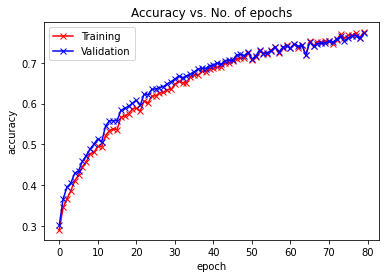

In [ ]:
import csv

def plot_accuracies(train_accuracies, test_accuracies):
    plt.plot(train_accuracies, '-rx')
    plt.plot(test_accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')

    if quaternion:
      with open('qnn', 'w') as f:
          # create the csv writer
          writer = csv.writer(f)

          # write a row to the csv file
          writer.writerow(test_accuracies)
          writer.writerow(train_losses)
    else:
      with open('cnn', 'w') as f:
          # create the csv writer
          writer = csv.writer(f)

          # write a row to the csv file
          writer.writerow(test_accuracies)
          writer.writerow(train_losses)

plot_accuracies(train_accuracies, test_accuracies)

## Plot results of the real-valued CNN

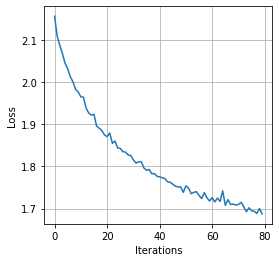

In [ ]:
# Plot training curves
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.grid()